In [1]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.6.0'

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.layers import ...

from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup

In [4]:
import pandas as pd
df = pd.read_csv('/content/sample_data/hdb_price_prediction.csv')
df.head()

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


In [5]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


#Question 1

Sub-section a

In [6]:
#Split data
train_dataframe = df[df['year'] <= 2020] # 0.8393471285568813
val_dataframe = df[df['year'] > 2020]
train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)
print(train_ds)

train_ds = train_ds.batch(128)
val_ds = val_ds.batch(128)

<ShuffleDataset shapes: ({month: (), year: (), full_address: (), nearest_stn: (), dist_to_nearest_stn: (), dist_to_dhoby: (), degree_centrality: (), eigenvector_centrality: (), flat_model_type: (), remaining_lease_years: (), floor_area_sqm: (), storey_range: ()}, ()), types: ({month: tf.int64, year: tf.int64, full_address: tf.string, nearest_stn: tf.string, dist_to_nearest_stn: tf.float64, dist_to_dhoby: tf.float64, degree_centrality: tf.float64, eigenvector_centrality: tf.float64, flat_model_type: tf.string, remaining_lease_years: tf.float64, floor_area_sqm: tf.float64, storey_range: tf.string}, tf.float64)>


Sub-section b

In [7]:
# Categorical features encoded as integers
month = keras.Input(shape=(1,), name="month", dtype="int64")
month_encoded = encode_categorical_feature(month, "month", train_ds, False)

# Categorical feature encoded as string
flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")

flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)


# Numerical features
dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")

dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)


all_inputs = [
    month,
    storey_range,
    flat_model_type,
    floor_area_sqm,
    remaining_lease_years,
    degree_centrality,
    eigenvector_centrality,
    dist_to_nearest_stn,
    dist_to_dhoby,
]


all_features = layers.concatenate(
    [
        month_encoded,
        storey_range_encoded,
        flat_model_type_encoded,
        floor_area_sqm_encoded,
        remaining_lease_years_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded,
    ]
)


Sub-section c

In [8]:
# feedforward network with one hidden layer
x = layers.Dense(10, activation="relu")(all_features)
# x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="linear")(x)


In [9]:
model = keras.Model(all_inputs, output)
opt=keras.optimizers.Adam(lr=0.05)
model.compile(optimizer=opt, loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])
history = model.fit(train_ds, epochs=100, validation_data=val_ds)#100 epochs needed

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Epoch 1/100
683/683 [==============================] - 4s 4ms/step - loss: 187177746432.0000 - mean_squared_error: 187177746432.0000 - val_loss: 170675044352.0000 - val_mean_squared_error: 170675044352.0000
Epoch 2/100
683/683 [==============================] - 3s 4ms/step - loss: 67174195200.0000 - mean_squared_error: 67174195200.0000 - val_loss: 39814365184.0000 - val_mean_squared_error: 39814365184.0000
Epoch 3/100
683/683 [==============================] - 3s 4ms/step - loss: 10811352064.0000 - mean_squared_error: 10811352064.0000 - val_loss: 11000289280.0000 - val_mean_squared_error: 11000289280.0000
Epoch 4/100
683/683 [==============================] - 3s 4ms/step - loss: 5528955392.0000 - mean_squared_error: 5528955392.0000 - val_loss: 8578768384.0000 - val_mean_squared_error: 8578768384.0000
Epoch 5/100
683/683 [==============================] - 3s 4ms/step - loss: 4995456512.0000 - mean_squared_error: 4995456512.0000 - val_loss: 7987132928.0000 - val_mean_squared_error: 79871

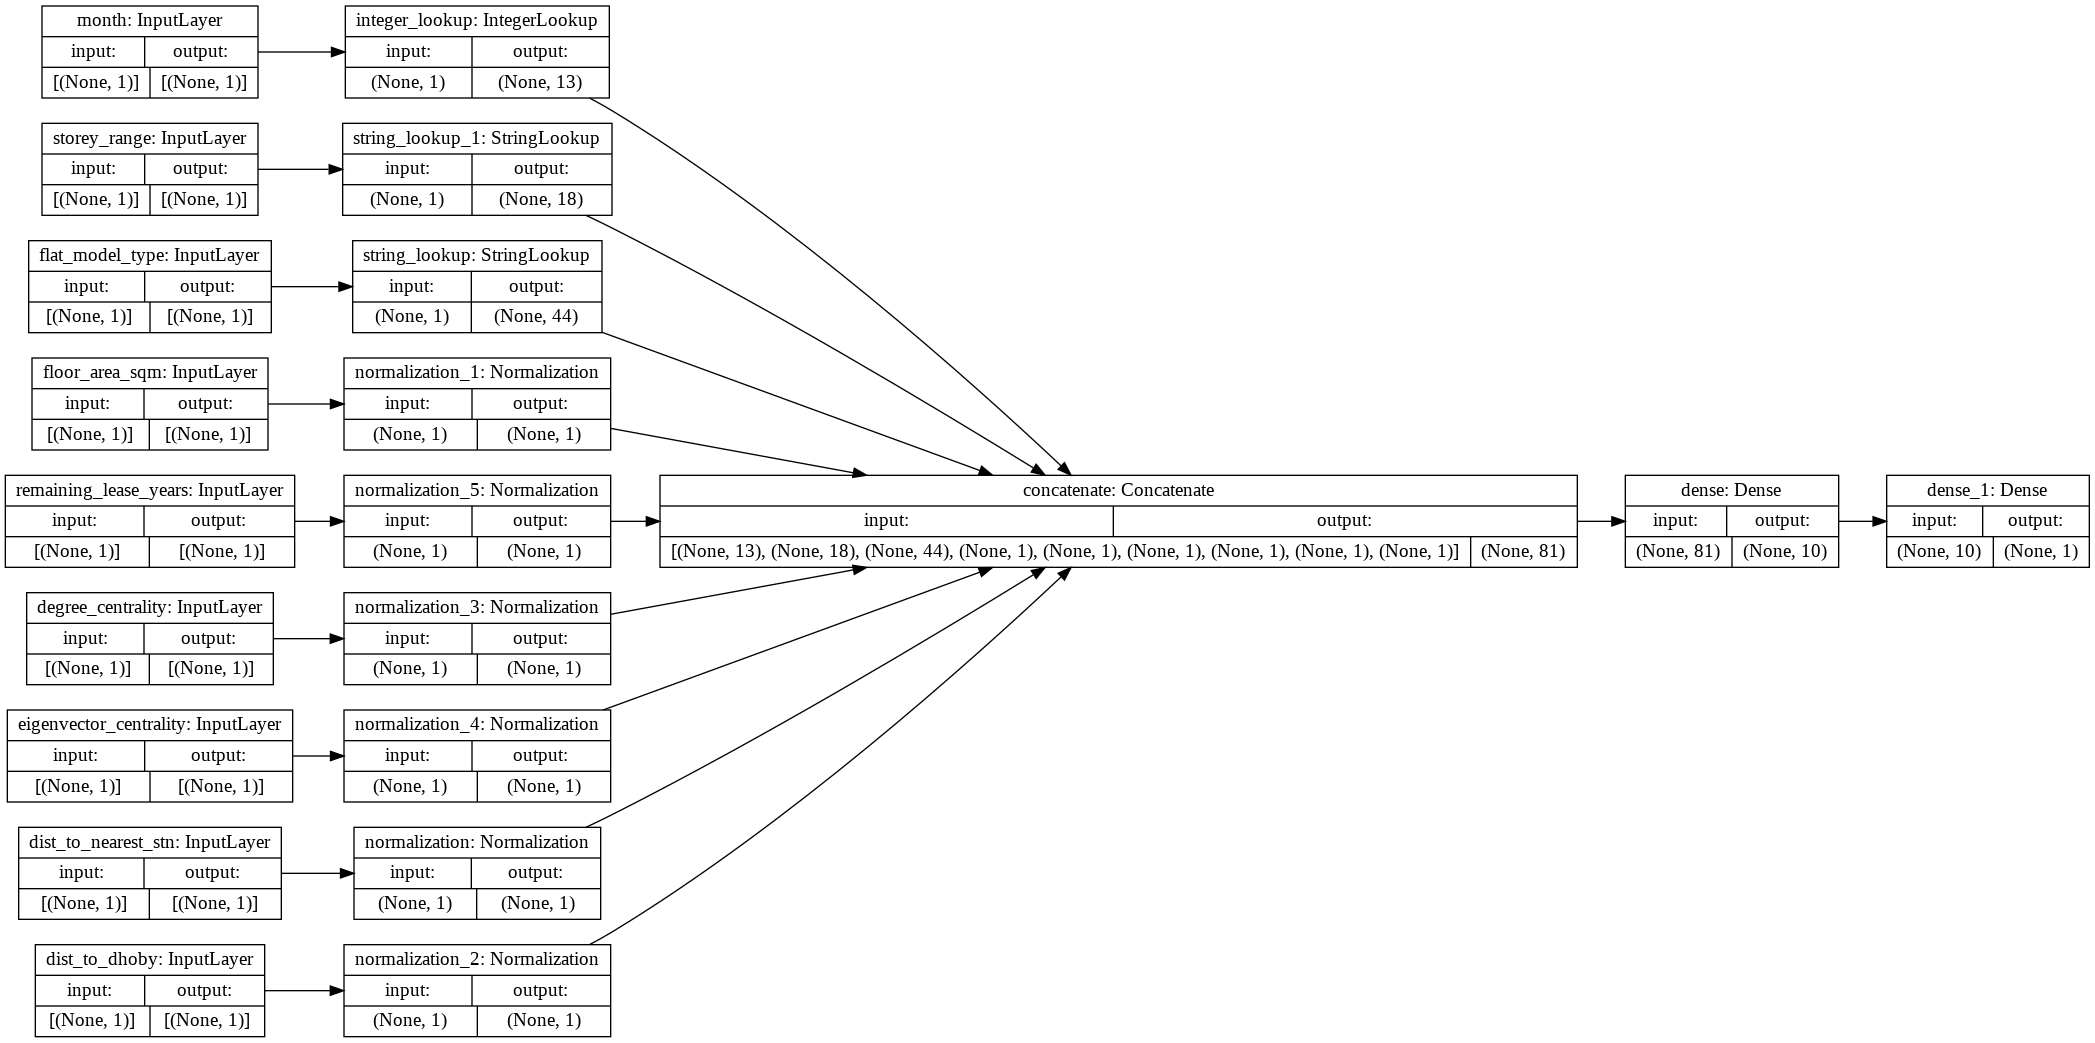

In [10]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

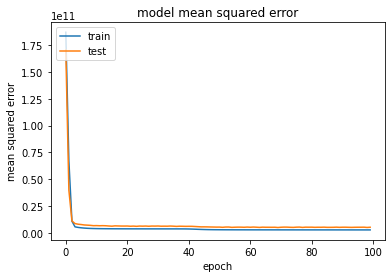

In [11]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mean squared error')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
# feedforward network with one hidden layer
y = layers.Dense(10, activation="relu")(all_features)
# x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="linear")(y)

Sub-section d,e

In [13]:
import tensorflow as tf
from keras import backend as K

#How to rewrite the r2_score
def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [14]:
model = keras.Model(all_inputs, output)
opt=keras.optimizers.Adam(lr=0.05)
#tf.keras.metrics.RootMeanSquaredError()
model.compile(optimizer=opt, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(), r2_score])
history = model.fit(train_ds, epochs=100, validation_data=val_ds)#100 epochs needed

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Epoch 1/100
683/683 [==============================] - 4s 5ms/step - loss: 199169900544.0000 - root_mean_squared_error: 446284.5625 - r2_score: -7.5574 - val_loss: 208276045824.0000 - val_root_mean_squared_error: 456372.7188 - val_r2_score: -7.1698
Epoch 2/100
683/683 [==============================] - 3s 4ms/step - loss: 103839490048.0000 - root_mean_squared_error: 322241.3438 - r2_score: -3.4511 - val_loss: 77222412288.0000 - val_root_mean_squared_error: 277889.2188 - val_r2_score: -2.0138
Epoch 3/100
683/683 [==============================] - 3s 4ms/step - loss: 24409937920.0000 - root_mean_squared_error: 156236.7969 - r2_score: -0.0415 - val_loss: 18659639296.0000 - val_root_mean_squared_error: 136600.2969 - val_r2_score: 0.2739
Epoch 4/100
683/683 [==============================] - 3s 4ms/step - loss: 6743917568.0000 - root_mean_squared_error: 82121.3594 - r2_score: 0.7136 - val_loss: 9654753280.0000 - val_root_mean_squared_error: 98258.6016 - val_r2_score: 0.6264
Epoch 5/100
683/

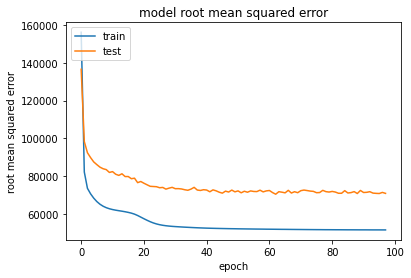

In [15]:
plt.plot(history.history['root_mean_squared_error'][2:])
plt.plot(history.history['val_root_mean_squared_error'][2:])
plt.title('model root mean squared error')
plt.ylabel('root mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

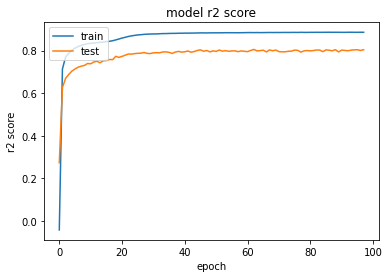

In [16]:
plt.plot(history.history['r2_score'][2:])
plt.plot(history.history['val_r2_score'][2:])
plt.title('model r2 score')
plt.ylabel('r2 score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
lowest_test_error=history.history['val_loss'] #This is a list
minimum_error=min(lowest_test_error)
print(minimum_error)
index = [i for i, x in enumerate(lowest_test_error) if x == min(lowest_test_error)]
best_epoch= [i+1 for i in index]
print(best_epoch)
best_r2_value=history.history['val_r2_score'][index[0]]
# best_r2_value=min(r2_value)
print(best_r2_value)

4950943744.0
[65]
0.8056017756462097


Sub-section f

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint
# checkpoint_filepath = 'weights.{epoch:02d}-{val_loss:.2f}.h5'

In [21]:
checkpoint = ModelCheckpoint("best_model.tf", monitor='val_root_mean_squared_error', verbose=1,save_best_only=True, mode='min', period=1,save_weights_only=True)
opt=keras.optimizers.Adam(lr=0.05)
model.compile(optimizer=opt, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.fit(train_ds, epochs=100, validation_data=val_ds,verbose=1,callbacks=[checkpoint])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 [==============================] - 4s 4ms/step - loss: 2644162560.0000 - root_mean_squared_error: 51421.4219 - val_loss: 5147983872.0000 - val_root_mean_squared_error: 71749.4531

Epoch 00001: val_root_mean_squared_error improved from inf to 71749.45312, saving model to best_model.tf
Epoch 2/100
683/683 [==============================] - 3s 4ms/step - loss: 2643286272.0000 - root_mean_squared_error: 51412.8984 - val_loss: 4997656064.0000 - val_root_mean_squared_error: 70694.1016

Epoch 00002: val_root_mean_squared_error improved from 71749.45312 to 70694.10156, saving model to best_model.tf
Epoch 3/100
683/683 [==============================] - 3s 4ms/step - loss: 2642841856.0000 - root_mean_squared_error: 51408.5781 - val_loss: 5181225984.0000 - val_root_mean_squared_error: 71980.7344

Epoch 00003: val_root_mean_squared_error did not improve from 70694.10156
Epoch 4/100
683/683 [==============================] - 3s 4ms/step - loss: 2642841088.0000 - root_mean_squared_error: 51

In [22]:
model.load_weights("/content/best_model.tf")
# loaded_model.compile(loss='mse', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])

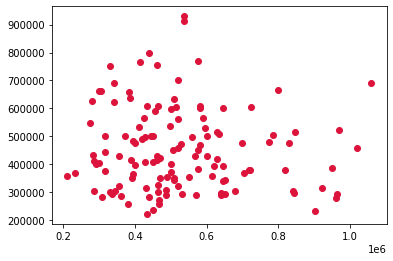

In [34]:
batch_128_samples=val_ds.take(1)
batch_128_samples_list = list(batch_128_samples.as_numpy_iterator())
prediction= model.predict(batch_128_samples)
# print(type(prediction))
plt.scatter(batch_128_samples_list[0][1], prediction, c='crimson') #(batch[1], prediction). 
# score = loaded_model.evaluate(train_ds, validation_data=val_ds, verbose=0)
# print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))



Question 2


Sub-section a,b

In [35]:
from math import *
# Categorical features encoded as integers using embedding to make more meaning ful sense of words
month_unique = df['month'].unique()
month_vocab_size = len(month_unique)
month_output_dim = month_vocab_size//2 #output_dim = floor(num_categories/2)
month_embedded = layers.Embedding(month_vocab_size,month_output_dim)(month_encoded)
month_flattened = layers.Flatten()(month_embedded)

flat_type_unique = df['flat_model_type'].unique()
flat_vocab_size = len(flat_type_unique)
flat_output_dim = flat_vocab_size//2 #output_dim = floor(num_categories/2)
flat_model_embedded = layers.Embedding(flat_vocab_size,flat_output_dim)(flat_model_type_encoded)
flat_model_type_flattened = layers.Flatten()(flat_model_embedded)

storey_unique = df['storey_range'].unique()
storey_vocab_size = len(storey_unique)
storey_output_dim = storey_vocab_size//2 #output_dim = floor(num_categories/2)
storey_range_embedded = layers.Embedding(storey_vocab_size,storey_output_dim)(storey_range_encoded)
storey_range_flattened = layers.Flatten()(storey_range_embedded)

all_inputs = [
    month,
    storey_range,
    flat_model_type,
    floor_area_sqm,
    remaining_lease_years,
    degree_centrality,
    eigenvector_centrality,
    dist_to_nearest_stn,
    dist_to_dhoby,
]

all_features_new = layers.concatenate(
    [
        month_flattened,
        storey_range_flattened,
        flat_model_type_flattened,
        floor_area_sqm_encoded,
        remaining_lease_years_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded,
    ]
)

all = [ month_flattened,
        storey_range_flattened,
        flat_model_type_flattened,
        floor_area_sqm_encoded,
        remaining_lease_years_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded
       
]

In [36]:
# feedforward network with one hidden layer
z = layers.Dense(10, activation="relu")(all_features_new)
# x = layers.Dropout(0.5)(x)
output_z = layers.Dense(1, activation="linear")(z)

In [37]:
model = keras.Model(all_inputs, output_z)
opt=keras.optimizers.Adam(lr=0.05)
model.compile(optimizer=opt, loss='mse', metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError(), r2_score])
history_question_2 = model.fit(train_ds, epochs=100, validation_data=val_ds)#100 epochs needed

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Epoch 1/100
683/683 [==============================] - 6s 6ms/step - loss: 35585642496.0000 - mean_squared_error: 35585642496.0000 - root_mean_squared_error: 188641.5781 - r2_score: -0.4983 - val_loss: 25828438016.0000 - val_mean_squared_error: 25828438016.0000 - val_root_mean_squared_error: 160712.2812 - val_r2_score: 0.0065
Epoch 2/100
683/683 [==============================] - 4s 6ms/step - loss: 12577115136.0000 - mean_squared_error: 12577115136.0000 - root_mean_squared_error: 112147.7344 - r2_score: 0.4668 - val_loss: 11670385664.0000 - val_mean_squared_error: 11670385664.0000 - val_root_mean_squared_error: 108029.5625 - val_r2_score: 0.5483
Epoch 3/100
683/683 [==============================] - 4s 6ms/step - loss: 8122588160.0000 - mean_squared_error: 8122588160.0000 - root_mean_squared_error: 90125.4062 - r2_score: 0.6525 - val_loss: 9168022528.0000 - val_mean_squared_error: 9168022528.0000 - val_root_mean_squared_error: 95749.7891 - val_r2_score: 0.6446
Epoch 4/100
683/683 [===

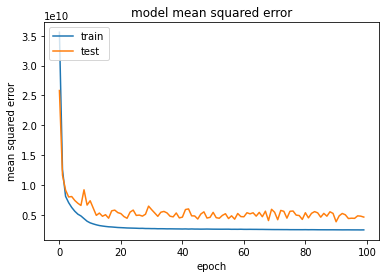

In [38]:
plt.plot(history_question_2.history['mean_squared_error'])
plt.plot(history_question_2.history['val_mean_squared_error'])
plt.title('model mean squared error')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


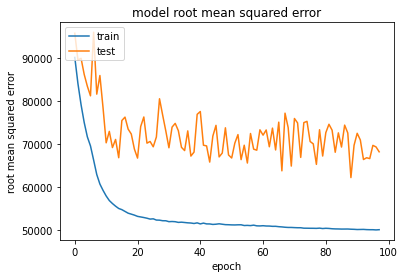

In [39]:
plt.plot(history_question_2.history['root_mean_squared_error'][2:])
plt.plot(history_question_2.history['val_root_mean_squared_error'][2:])
plt.title('model root mean squared error')
plt.ylabel('root mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


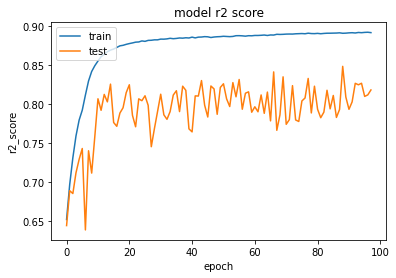

In [40]:
plt.plot(history_question_2.history['r2_score'][2:])
plt.plot(history_question_2.history['val_r2_score'][2:])
plt.title('model r2 score')
plt.ylabel('r2_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


Question 3

In [41]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [42]:
history_early_stopping = model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[es])

Epoch 1/100
683/683 [==============================] - 4s 6ms/step - loss: 2494242304.0000 - mean_squared_error: 2494242304.0000 - root_mean_squared_error: 49942.3906 - r2_score: 0.8929 - val_loss: 4352741888.0000 - val_mean_squared_error: 4352741888.0000 - val_root_mean_squared_error: 65975.3125 - val_r2_score: 0.8296
Epoch 2/100
683/683 [==============================] - 4s 6ms/step - loss: 2494327808.0000 - mean_squared_error: 2494327808.0000 - root_mean_squared_error: 49943.2461 - r2_score: 0.8926 - val_loss: 5234001920.0000 - val_mean_squared_error: 5234001920.0000 - val_root_mean_squared_error: 72346.3984 - val_r2_score: 0.7950
Epoch 3/100
683/683 [==============================] - 4s 6ms/step - loss: 2497934080.0000 - mean_squared_error: 2497934080.0000 - root_mean_squared_error: 49979.3359 - r2_score: 0.8924 - val_loss: 4438603264.0000 - val_mean_squared_error: 4438603264.0000 - val_root_mean_squared_error: 66622.8438 - val_r2_score: 0.8263
Epoch 4/100
683/683 [================

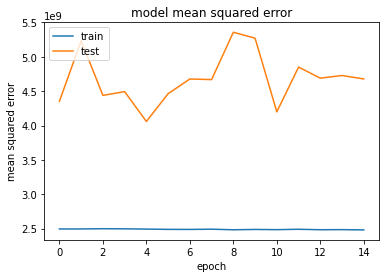

In [43]:
plt.plot(history_early_stopping.history['mean_squared_error'])
plt.plot(history_early_stopping.history['val_mean_squared_error'])
plt.title('model mean squared error')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


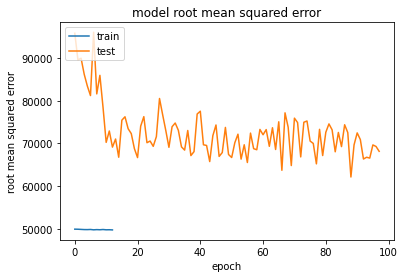

In [44]:
plt.plot(history_early_stopping.history['root_mean_squared_error'][2:])
plt.plot(history_question_2.history['val_root_mean_squared_error'][2:])
plt.title('model root mean squared error')
plt.ylabel('root mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

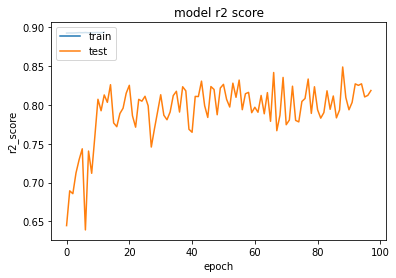

In [45]:
plt.plot(history_early_stopping.history['r2_score'][2:])
plt.plot(history_question_2.history['val_r2_score'][2:])
plt.title('model r2 score')
plt.ylabel('r2_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [46]:
val_loss_question_2 = min(history_early_stopping.history['val_loss'])
print(val_loss_question_2)

4058749696.0


In [47]:
def feature_model(input_features): #, num_features, model_count
  # model_name="best_model"+"_"+str(num_features)+"_"+str(model_count)
  fea = layers.Dense(10, activation="relu")(input_features)
  output_fea = layers.Dense(1, activation="linear")(fea)
  model = keras.Model(all_inputs, output_fea)
  opt=keras.optimizers.Adam(lr=0.05)
  model.compile(optimizer=opt, loss='mse', metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError(), r2_score])
  history_model = model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[es]) #need 100 epochs
  return history_model

In [48]:
def RecursiveFeatureExtraction(feature_list,dummy_list, best_performance_model): #Recursive Feature Extraction all_inputs,
  rfe={}
  comp_val_loss={}
  good_features=[]
  for i in range(len(feature_list)):
    feature_combinations = feature_list[:i] + feature_list[i+1:]
    features_dummy = dummy_list[:i] + dummy_list[i+1:]
    concatenated_features = layers.concatenate(feature_combinations)
    rfe[dummy_list[i]] = feature_model(concatenated_features)#
    comp_val_loss[dummy_list[i]] = min(rfe[dummy_list[i]].history['val_loss'])
    # find key with lowest value
    best_history_model = min(comp_val_loss, key=comp_val_loss.get)
    if(comp_val_loss[best_history_model]<val_loss_question_2):
      good_features = feature_combinations
      best_features_history=rfe[best_history_model]
      best_features_dummy = features_dummy

    if(len(good_features)>0):
      RecursiveFeatureExtraction(good_features,best_features_dummy, best_features_history)

  best_performance_model = [feature_list, rfe[best_history_model]]
  return best_performance_model



In [49]:
best_performance_model=[]
dummy_list = ["month_flattened",
        "storey_range_flattened",
        "flat_model_type_flattened",
        "floor_area_sqm_encoded",
        "remaining_lease_years_encoded",
        "degree_centrality_encoded",
        "eigenvector_centrality_encoded",
        "dist_to_nearest_stn_encoded",
        "dist_to_dhoby_encoded"]
best_performance_model = RecursiveFeatureExtraction(all, dummy_list, best_performance_model)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Epoch 1/100
683/683 [==============================] - 5s 6ms/step - loss: 32349978624.0000 - mean_squared_error: 32349978624.0000 - root_mean_squared_error: 179861.0000 - r2_score: -0.3689 - val_loss: 17129508864.0000 - val_mean_squared_error: 17129508864.0000 - val_root_mean_squared_error: 130879.7500 - val_r2_score: 0.3425
Epoch 2/100
683/683 [==============================] - 4s 6ms/step - loss: 9852566528.0000 - mean_squared_error: 9852566528.0000 - root_mean_squared_error: 99260.0938 - r2_score: 0.5812 - val_loss: 12085366784.0000 - val_mean_squared_error: 12085366784.0000 - val_root_mean_squared_error: 109933.4688 - val_r2_score: 0.5302
Epoch 3/100
683/683 [==============================] - 4s 6ms/step - loss: 8175002624.0000 - mean_squared_error: 8175002624.0000 - root_mean_squared_error: 90415.7188 - r2_score: 0.6505 - val_loss: 9737860096.0000 - val_mean_squared_error: 9737860096.0000 - val_root_mean_squared_error: 98680.5938 - val_r2_score: 0.6231
Epoch 4/100
683/683 [======

In [62]:
print("Necessary features(In Tensor Shapes):", best_performance_model[0])

Necessary features(In Tensor Shapes): [<KerasTensor: shape=(None, 78) dtype=float32 (created by layer 'flatten')>, <KerasTensor: shape=(None, 144) dtype=float32 (created by layer 'flatten_2')>, <KerasTensor: shape=(None, 924) dtype=float32 (created by layer 'flatten_1')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_1')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_5')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_3')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_4')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_2')>]


In [61]:
print("History object:", best_performance_model[1])

History object: <keras.callbacks.History object at 0x7f462987c6d0>


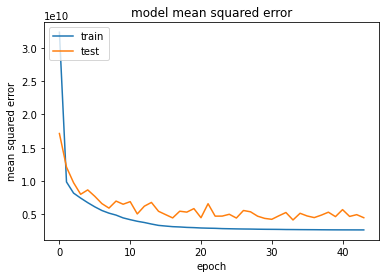

In [54]:
history_best_model = best_performance_model[1].history
plt.plot(history_best_model['mean_squared_error'])
plt.plot(history_best_model['val_mean_squared_error'])
plt.title('model mean squared error')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

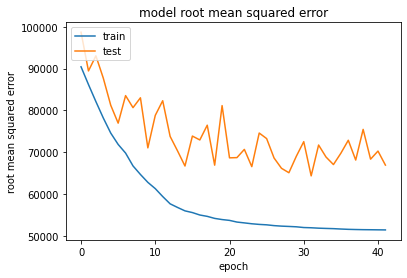

In [55]:
plt.plot(history_best_model['root_mean_squared_error'][2:])
plt.plot(history_best_model['val_root_mean_squared_error'][2:])
plt.title('model root mean squared error')
plt.ylabel('root mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

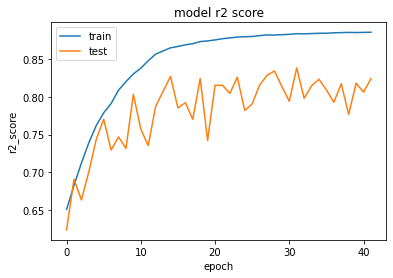

In [56]:
plt.plot(history_best_model['r2_score'][2:])
plt.plot(history_best_model['val_r2_score'][2:])
plt.title('model r2 score')
plt.ylabel('r2_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()